In [1]:
!pip install -q pathlib matplotlib torch tqdm torchxrayvision numpy torchxrayvision

!git clone https://github.com/ieee8023/covid-chestxray-dataset

     |████████████████████████████████| 25.0MB 127kB/s 
     |████████████████████████████████| 1.9MB 53.9MB/s 
Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3641 (delta 4), reused 6 (delta 2), pack-reused 3629
Receiving objects: 100% (3641/3641), 632.97 MiB | 45.96 MiB/s, done.
Resolving deltas: 100% (1446/1446), done.
Checking out files: 100% (1174/1174), done.


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchxrayvision as xrv
import torch.optim as optim
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]

    _, pred = torch.max(output, dim=-1)

    correct = pred.eq(target).sum() * 1.0

    acc = correct / batch_size

    return acc

In [ ]:
def main():
    PATH = Path('./covid-chestxray-dataset')

    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])

    dataset = xrv.datasets.COVID19_Dataset(imgpath=PATH/'images', csvpath=PATH/'metadata.csv', transform=transform)

    print(dataset)

    len_dataset = len(dataset)
    n_train = int(0.8*len_dataset)
    n_test = int(0.2*len_dataset)
    print(f'Total samples: {len_dataset}, train size size: {n_train}, test set size: {n_test}')

    train_ds, test_ds = torch.utils.data.random_split(dataset, [n_train,n_test])
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=True, num_workers=1)

    model = xrv.models.DenseNet(num_classes=2).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.99)

    features = 'img' #
    target = 'lab'  #

    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    for epoch in tqdm(range(100)):  # loop over the dataset multiple times

        running_loss = AverageMeter()
        running_acc = AverageMeter()
        for i, data in enumerate(train_dl):

            inputs = data[features].cuda()
            labels = data[target].long().cuda()
            labels = labels[:, 3]

            # get the inputs; data is a list of [inputs, labels]
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_acc = accuracy(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss.update(loss.item(), outputs.shape[0])
            running_acc.update(train_acc, outputs.shape[0])

        test_loss = AverageMeter()
        test_acc = AverageMeter()
        for i, data in enumerate(test_dl):
            inputs = data[features].cuda()
            labels = data[target].long().cuda()
            labels = labels[:, 3]

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_acc = accuracy(outputs, labels)

            # print statistics
            test_loss.update(loss.item(), outputs.shape[0])
            test_acc.update(train_acc, outputs.shape[0])

        train_loss_history.append(running_loss.avg)
        train_acc_history.append(running_acc.avg)
        valid_loss_history.append(test_loss.avg)
        valid_acc_history.append(test_acc.avg)

    plt.plot(train_loss_history, label='training loss')
    plt.plot(valid_loss_history, label='validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label='training accuracy')
    plt.plot(valid_acc_history, label='validation accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

{'Aspergillosis': {0.0: 534, 1.0: 1},
 'Aspiration': {0.0: 534, 1.0: 1},
 'Bacterial': {0.0: 487, 1.0: 48},
 'COVID-19': {0.0: 193, 1.0: 342},
 'Chlamydophila': {0.0: 534, 1.0: 1},
 'Fungal': {0.0: 512, 1.0: 23},
 'H1N1': {0.0: 534, 1.0: 1},
 'Herpes ': {0.0: 532, 1.0: 3},
 'Influenza': {0.0: 531, 1.0: 4},
 'Klebsiella': {0.0: 526, 1.0: 9},
 'Legionella': {0.0: 526, 1.0: 9},
 'Lipoid': {0.0: 527, 1.0: 8},
 'MERS-CoV': {0.0: 527, 1.0: 8},
 'MRSA': {0.0: 534, 1.0: 1},
 'Mycoplasma': {0.0: 530, 1.0: 5},
 'No Finding': {0.0: 520, 1.0: 15},
 'Nocardia': {0.0: 531, 1.0: 4},
 'Pneumocystis': {0.0: 513, 1.0: 22},
 'Pneumonia': {0.0: 26, 1.0: 509},
 'SARS': {0.0: 519, 1.0: 16},
 'Staphylococcus': {0.0: 534, 1.0: 1},
 'Streptococcus': {0.0: 518, 1.0: 17},
 'Tuberculosis': {0.0: 524, 1.0: 11},
 'Varicella': {0.0: 530, 1.0: 5},
 'Viral': {0.0: 157, 1.0: 378}}
COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None
Total samples: 535, train size size: 428, test set size: 107


100%|██████████| 100/100 [1:30:41<00:00, 54.41s/it]


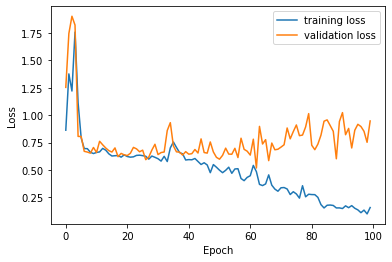

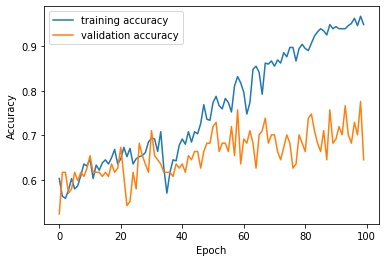

In [ ]:
main()

{'Aspergillosis': 0.0,
 'Aspiration': 0.0,
 'Bacterial': 0.0,
 'COVID-19': 0.0,
 'Chlamydophila': 0.0,
 'Fungal': 0.0,
 'H1N1': 0.0,
 'Herpes ': 0.0,
 'Influenza': 1.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'Lipoid': 0.0,
 'MERS-CoV': 0.0,
 'MRSA': 0.0,
 'Mycoplasma': 0.0,
 'No Finding': 0.0,
 'Nocardia': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Staphylococcus': 0.0,
 'Streptococcus': 0.0,
 'Tuberculosis': 0.0,
 'Varicella': 0.0,
 'Viral': 1.0}

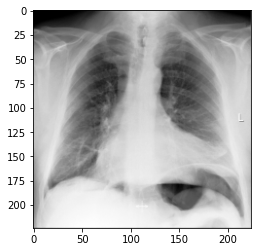

In [13]:
PATH = Path('./covid-chestxray-dataset')

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])

dataset = xrv.datasets.COVID19_Dataset(imgpath=PATH/'images', csvpath=PATH/'metadata.csv', transform=transform)

sample = dataset[318]  #0 has covid 19  15 has SARS
plt.imshow(sample["img"][0], cmap="Greys_r");
dict(zip(dataset.pathologies,sample["lab"]))